In [2]:
import pymongo
import re
import requests
import pandas as pd
import numpy as np
import urllib
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [3]:
client = pymongo.MongoClient('35.167.189.162', 27016)

In [4]:
client.database_names()

['admin', 'local', 'project4_database', 'test', 'twitter']

In [5]:
db_ref = client.project4_database

In [8]:
coll_ref = db_ref.my_project4_combined_df

In [9]:
client.database_names(), db_ref.collection_names()

(['admin', 'local', 'project4_database', 'test', 'twitter'],
 ['my_project4_collection',
  'my_project4_collection_bs',
  'my_project4_combined_df'])

In [10]:
cursor = coll_ref.find_one()

cursor

sample_docs = (cursor)

In [11]:
type(sample_docs)

dict

In [12]:
sample_docs.keys()

dict_keys(['_id', 'pageid', 'category', 'text', 'title'])

In [13]:
from_mongo_combined = pd.DataFrame(sample_docs)

In [14]:
from_mongo_combined.shape

(2993, 5)

In [15]:
from_mongo_combined.head()

,_id,category,pageid,text,title
0,5a1a0a2db97736002e75b32c,Machine learning,43385931,data exploration is an approach similar to ini...,Data exploration
1,5a1a0a2db97736002e75b32c,Machine learning,49082762,these datasets are used for machinelearning re...,List of datasets for machine learning research
10,5a1a0a2db97736002e75b32c,Machine learning,10435998,katia sycara greek is a professor in the robot...,Katia Sycara
100,5a1a0a2db97736002e75b32c,Machine learning,871681,in statistics a mixture model is a probabilist...,Mixture model
1000,5a1a0a2db97736002e75b32c,Machine learning,20768311,pierre baldi is a chancellors professor of com...,Pierre Baldi


In [16]:
df = from_mongo_combined.drop(['_id', ], axis=1) 

In [17]:
df = df.set_index(['pageid'])

In [19]:
df.shape

(2993, 3)

### Label Encode the Categories


In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
le = LabelEncoder()
df['category_numerical'] = le.fit_transform(df['category'])

In [22]:
df.shape

(2993, 4)

In [23]:
df.category_numerical.unique()

array([1, 0])

In [31]:
smp30_df = df.sample(900)

In [32]:
smp30_df.shape

(900, 4)

### Prepare Document Term Matrix


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
tfidf_vectorizer = TfidfVectorizer(min_df = 1, stop_words = 'english')

### TFIDF


In [33]:
document_term_matrix_sps = tfidf_vectorizer.fit_transform(smp30_df.text)

In [34]:
document_term_matrix_sps

<900x38992 sparse matrix of type '<class 'numpy.float64'>'
	with 208358 stored elements in Compressed Sparse Row format>

In [35]:
document_term_matrix_df = pd.DataFrame(document_term_matrix_sps.toarray(),
                                       index=smp30_df.index,
                                       columns=tfidf_vectorizer.get_feature_names())

In [36]:
pd.concat([smp30_df.text, document_term_matrix_df], axis=1).sample(4)

,text,aa,aaa,aaai,aaainumber,aaas,aabright,aai,aais,aalborg,...,zurich,zwanziger,zwart,zwire,zwischen,zx,zxtimes,zynga,zyngas,zzapnumber
pageid,,,,,,,,,,,,,,,,,,,,,
46753621,mileiq is an americanbased technology company ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21138330,membership software also known as an associati...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6987871,governance risk management and compliance or g...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47459238,ndNUMBER s is a free opensource extension of t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Compute SVD of Document Term Matrix


In [37]:
from sklearn.decomposition import TruncatedSVD

In [38]:
n_components = 50
SVD = TruncatedSVD(n_components)
component_names = ["component_"+str(i+1) for i in range(n_components)]

In [39]:
svd_matrix = SVD.fit_transform(document_term_matrix_df)

In [40]:
sum(SVD.explained_variance_ratio_)

0.1973160479074843

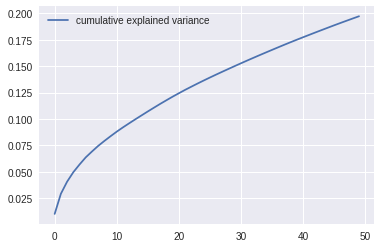

In [41]:
plt.plot(range(50), np.cumsum(SVD.explained_variance_ratio_), label='cumulative explained variance')
plt.legend()

#### Load SVD Matrix with Documents and Labels

In [42]:
latent_semantic_analysis = pd.DataFrame(svd_matrix,
                                        index=smp30_df.index,
                                        columns=component_names)
latent_semantic_analysis['text'] = smp30_df.text
latent_semantic_analysis['category'] = smp30_df.category

In [43]:
vocabulary_expression = pd.DataFrame(SVD.components_,
                                     index=component_names,
                                     columns=tfidf_vectorizer.get_feature_names()).T

In [44]:
for i in range(1,11):
    vocabulary_expression['abs_component_{}'.format(i)] = np.abs(vocabulary_expression['component_{}'.format(i)])

### Display Top Terms for Each Component

These are "topics".

In [45]:
vocabulary_expression['abs_component_1'].sort_values(ascending=False).head(7)

number          0.657584
displaystyle    0.383389
data            0.105473
learning        0.104918
game            0.101322
software        0.094848
management      0.082662
Name: abs_component_1, dtype: float64

In [46]:
vocabulary_expression['abs_component_2'].sort_values(ascending=False).head(7)

displaystyle    0.721801
number          0.187664
game            0.155353
software        0.126519
management      0.124438
mathbf          0.120924
mathcal         0.094309
Name: abs_component_2, dtype: float64

In [47]:
vocabulary_expression['abs_component_3'].sort_values(ascending=False).head(7)

game        0.556914
player      0.264611
tycoon      0.241084
players     0.157015
games       0.147087
data        0.128890
learning    0.127955
Name: abs_component_3, dtype: float64

In [48]:
vocabulary_expression['abs_component_4'].sort_values(ascending=False).head(7)

learning        0.291248
number          0.262536
game            0.247251
neural          0.212825
displaystyle    0.163522
machine         0.147754
data            0.135518
Name: abs_component_4, dtype: float64

In [49]:
vocabulary_expression['abs_component_5'].sort_values(ascending=False).head(7)

number          0.349632
displaystyle    0.282416
ndnumber        0.228656
java            0.189609
management      0.170347
game            0.150417
apache          0.143363
Name: abs_component_5, dtype: float64

In [50]:
vocabulary_expression['abs_component_6'].sort_values(ascending=False).head(7)

number        0.339609
ndnumber      0.281304
management    0.229457
business      0.190482
java          0.184270
sap           0.156013
apache        0.136298
Name: abs_component_6, dtype: float64

In [51]:
vocabulary_expression['abs_component_7'].sort_values(ascending=False).head(7)

server         0.263925
ndnumber       0.252766
java           0.237347
web            0.186033
application    0.160804
oracle         0.154138
ee             0.154136
Name: abs_component_7, dtype: float64